In [1]:
import sys
sys.path.append("../../library/")
sys.path.append("../lib/")
import numpy as np
import matplotlib.pyplot as plt
import read_data as rd
from scipy.optimize import minimize_scalar
from sub_plot import *
from defaultPlot import *
from dataProcess import *
from stringFormat import *


In [2]:
time = {}
points = {}
#* ---------------------------------------------------------
orderParameter = {}
netOrderParameter = {}
singleOrderParameter = {}
meanClusterSize = {}
orderParameterVariance = {}
netOrderParameterVariance = {}
interEventTime = {}
#* ---------------------------------------------------------
orderParameterDist_t = {}
orderParameterDist = {}
clusterSizeDist_op = {}
clusterSizeDist = {}

In [289]:
for networkSize in networkSizeList:
# for networkSize in [10240000]:
    time[networkSize] = np.arange(0.0, 1.0, 1/networkSize)
    # for acceptanceThreshold in acceptanceThresholdList:
    for acceptanceThreshold in [0.5]:
        current = networkSize, acceptanceThreshold
        # points[current] = rd.readPoints(networkSize, acceptanceThreshold)
        #* -------------------------------------------------------
        orderParameter[current] = rd.read("orderParameter", networkSize, acceptanceThreshold)
        meanClusterSize[current] = rd.read("meanClusterSize", networkSize, acceptanceThreshold)
        orderParameterVariance[current] = rd.read("orderParameterVariance", networkSize, acceptanceThreshold)
        # interEventTime[current] = rd.read("interEventTime", networkSize, acceptanceThreshold)
        netOrderParameter[current] = {}
        netOrderParameterVariance[current] = {}
        for accumulate in ["", "12", "78"]:
            for state in ["sub", "super"]:
                netOrderParameter[current][accumulate + state] = rd.read("netOrderParameter", networkSize, acceptanceThreshold, accumulate + state)
                netOrderParameterVariance[current][accumulate + state] = rd.read("netOrderParameterVariance", networkSize, acceptanceThreshold, accumulate + state)

        # singleOrderParameter[current] = rd.read("singleOrderParameter", networkSize, acceptanceThreshold)
        #* ---------------------------------------------------------
        # orderParameterDist_t[current] = rd.extractRepeater("orderParameterDist", networkSize, acceptanceThreshold)
        # for t in orderParameterDist_t[current]:
        #     orderParameterDist[current, t] = rd.read("orderParameterDist", networkSize, acceptanceThreshold, t)
        # clusterSizeDist_op[current] = rd.extractRepeater("clusterSizeDist", networkSize, acceptanceThreshold)
        # for op in clusterSizeDist_op[current]:
        #     clusterSizeDist[current, op] = rd.read("clusterSizeDist", networkSize, acceptanceThreshold, op)
        #* ---------------------------------------------------------

No file at ../data/netOrderParameter_mc/sub/N1.0e+04,G0.5*.txt
No file at ../data/netOrderParameterVariance_mc/sub/N1.0e+04,G0.5*.txt
No file at ../data/netOrderParameter_mc/super/N1.0e+04,G0.5*.txt
No file at ../data/netOrderParameterVariance_mc/super/N1.0e+04,G0.5*.txt
No file at ../data/netOrderParameterVariance_mc/sub/N2.0e+04,G0.5*.txt
No file at ../data/netOrderParameterVariance_mc/super/N2.0e+04,G0.5*.txt
No file at ../data/netOrderParameter_mc/sub/N4.0e+04,G0.5*.txt
No file at ../data/netOrderParameterVariance_mc/sub/N4.0e+04,G0.5*.txt
No file at ../data/netOrderParameter_mc/super/N4.0e+04,G0.5*.txt
No file at ../data/netOrderParameterVariance_mc/super/N4.0e+04,G0.5*.txt
No file at ../data/netOrderParameter_mc/sub/N8.0e+04,G0.5*.txt
No file at ../data/netOrderParameterVariance_mc/sub/N8.0e+04,G0.5*.txt
No file at ../data/netOrderParameter_mc/super/N8.0e+04,G0.5*.txt
No file at ../data/netOrderParameterVariance_mc/super/N8.0e+04,G0.5*.txt
No file at ../data/netOrderParameterVari

In [4]:
networkSize, acceptanceThreshold = 10240000, 0.5
current = networkSize, acceptanceThreshold
points[current] = rd.readPoints(networkSize, acceptanceThreshold)
t_c, m_c = points[current]["t_c"], points[current]["m_c"]

# Finding beta

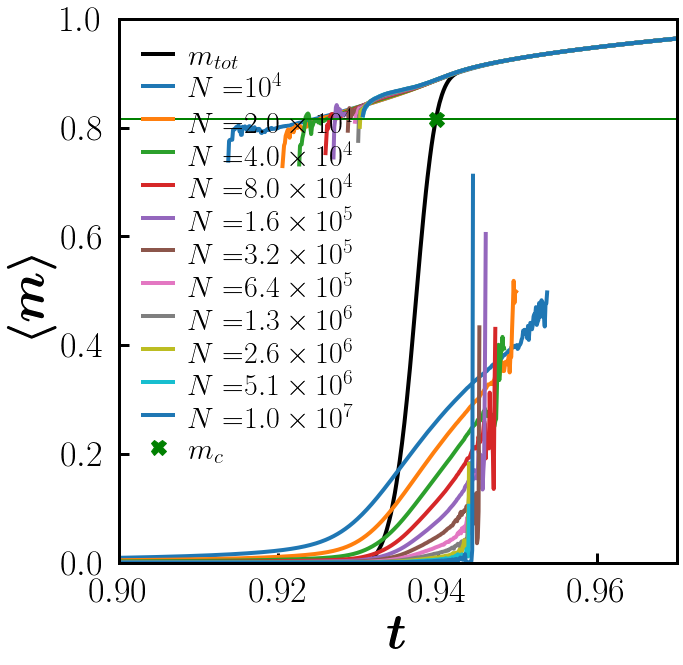

In [5]:
fig, ax = plt.subplots()
ax.set_rasterized(True)

t, op = avgLinBin(time[10240000], orderParameter[(10240000, 0.5)])
ax.plot(t, op, 'k-', label=latex_string("m_{tot}"))


def plotNetOP():
    for networkSize in networkSizeList:
        current = networkSize, acceptanceThreshold
        color = next(ax._get_lines.prop_cycler)['color']
        net_t, net_op = avgLinBin(*netOrderParameter[current]["78sub"], min_val=0, max_val=networkSize - 1, delta=networkSize / 1e4)
        ax.plot(net_t / networkSize, net_op, color = color)
        net_t, net_op = avgLinBin(*netOrderParameter[current]["78super"], min_val=0, max_val=networkSize - 1, delta=networkSize / 1e4)
        ax.plot(net_t / networkSize, net_op, label=latex_string("N=") + latex_sci(networkSize, 1), color = color)

plotNetOP()

ax.plot([0, 1], [m_c, m_c], 'g-', linewidth=2)
ax.plot(t_c, m_c, 'gX', label=latex_string("m_c"))
ax.set_xlim(0.9, 0.97)
ax.set_ylim(0, 1)
ax.set_xlabel(latex_bold_string("t"))
ax.set_ylabel(latex_bold_string("\langle m \\rangle"))
ax.legend(loc="best", fontsize=30)

fig.show()

beta: 0.625 nu_bar: 2.5
-0.039403603793243924
-0.02474796431666837
-0.013773614103437137
-0.004436614271457029
0.001310736245954569


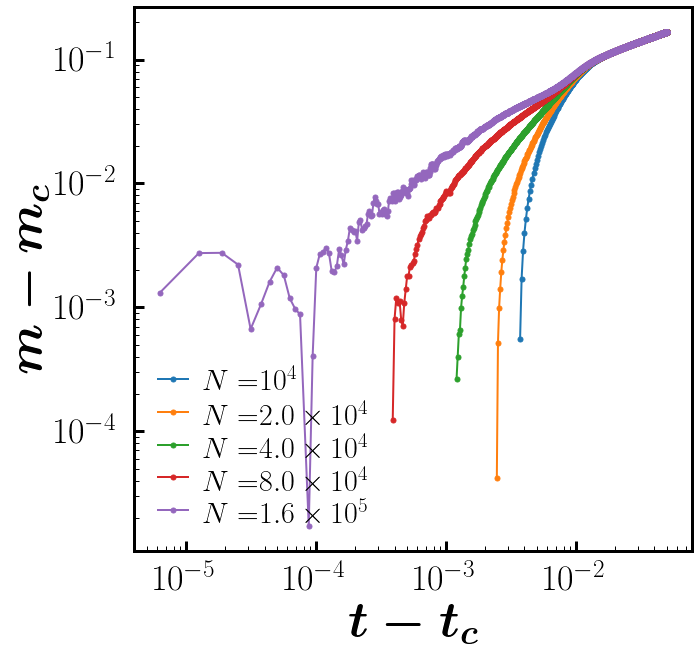

In [303]:
fig, ax = plt.subplots()
ax.set_rasterized(True)

t_c, m_c= 0.930, 0.81
x, nu_bar = 0.25, 2.5
beta = x * nu_bar

print("beta:", beta, "nu_bar:", nu_bar)
def plotBeta(net, scaled):
    for networkSize in [10000, 20000, 40000, 80000, 160000]:
    # for networkSize in [20000, 160000, 1280000, 10240000]:
        current = networkSize, acceptanceThreshold
        if net:
            t, op = netOrderParameter[current]["12super"]
            # t, op = netOrderParameter[current]["78super"]
        else:
            t, op = time[networkSize]*networkSize, orderParameter[current]
        reduced_t, reduced_op = t - t_c*networkSize, op-m_c
        reduced_t, reduced_op = reduced_t[reduced_t>0], reduced_op[reduced_t > 0]
        print(reduced_op[0])
        reduced_t, reduced_op = reduced_t[reduced_t<networkSize*5e-2], reduced_op[reduced_t < networkSize*5e-2]
        # reduced_t, reduced_op = avgLogBin(reduced_t[reduced_op>0], reduced_op[reduced_op>0], delta_exponent=0.05)
        reduced_t, reduced_op = reduced_t[reduced_op>0], reduced_op[reduced_op>0]
        reduced_t /= networkSize
        if scaled:
            ax.plot(reduced_t * np.power(networkSize, 1/nu_bar), reduced_op * np.power(networkSize, x), 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), linewidth=2, markersize=5)
        else:
            ax.plot(reduced_t, reduced_op, 'o-', label=latex_string("N=") + latex_sci(networkSize, 1),linewidth=2, markersize=5)
    if scaled:
        ax.set_xlabel(latex_bold_string("(t-t_c) N^{1/\\bar{\\nu}}"))
        ax.set_ylabel(latex_bold_string("(m-m_c) N^{\\beta/\\bar{\\nu}}"))
    else:
        ax.set_xlabel(latex_bold_string("t-t_c"))
        ax.set_ylabel(latex_bold_string("m-m_c"))

plotBeta(net=True, scaled=False)
# x = np.array([1e-2, 10])
# y = np.power(x, beta) * 1
# ax.plot(x,y,'k--', label=latex_string("\\beta=") + latex_float(beta, 2), linewidth=2)


# plotBeta(net=False, scaled=False)
# x = np.array([1e-2, 10])
# y = np.power(x, beta) * 1
# ax.plot(x,y,'k--', label=latex_string("\\beta=") + latex_float(beta, 2))

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc="best", fontsize=30)


fig.show()


# Susceptibility

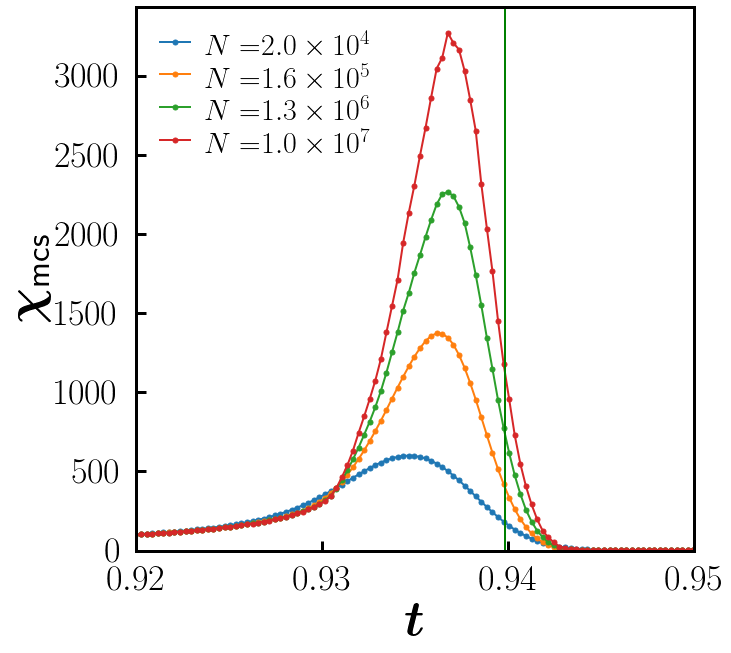

In [103]:
fig, ax = plt.subplots()
ax.set_rasterized(True)

def plotMCS(acceptanceThreshold):
    for networkSize in [20000, 160000, 1280000, 10240000]:
        current = networkSize, acceptanceThreshold
        t, chi = avgLinBin(time[networkSize], meanClusterSize[current], delta=3e-4)
        # t, chi = time[networkSize], meanClusterSize[current]
        ax.plot(t, chi, 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), markersize=5, linewidth=2)
    ax.set_xlabel(latex_bold_string("t"))
    ax.set_ylabel(latex_bold_string("\chi_\\text{mcs}"))
    ax.set_xlim(chi_plotRange[acceptanceThreshold])
    ax.set_ylim(bottom = 0)
    ax.legend(loc="best", fontsize=30)

plotMCS(0.5)

t_c = points[current]["t_c"]
ax.plot([t_c,t_c], [0, 10000], 'g-', linewidth=2)

fig.show()


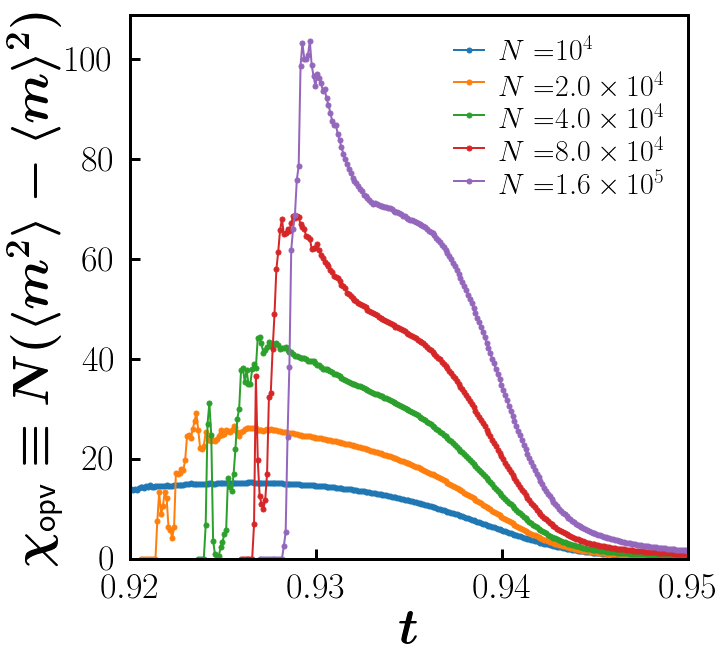

In [197]:
fig, ax = plt.subplots()
ax.set_rasterized(True)


def plotOPV(networkSize):
    current = networkSize, acceptanceThreshold
    t, chi = avgLinBin(time[networkSize], np.nan_to_num(orderParameterVariance[current], 0.0))
    ax.plot(t, chi, 'k-', label=latex_string("N=") + latex_sci(networkSize, 1), linewidth=2)

def plotNetOPV(networkSize):
    current = networkSize, acceptanceThreshold
    t,chi = avgLinBin(*netOrderParameterVariance[current]["78super"], min_val=0, max_val=networkSize-1, delta=networkSize*1e-4)
    ax.plot(t/networkSize, chi, 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), markersize=5, linewidth=2)

# plotOPV(10000)
plotNetOPV(10000)
plotNetOPV(20000)
plotNetOPV(40000)
plotNetOPV(80000)
plotNetOPV(160000)


# ax.plot([t_c,t_c], [0, 2e6], 'g-', linewidth=2)
ax.set_xlabel(latex_bold_string("t"))
ax.set_ylabel(latex_bold_string("\chi_\\text{opv} \equiv N(\langle m^2\\rangle - \langle m \\rangle ^2)"))
ax.set_xlim(chi_plotRange[acceptanceThreshold])
ax.set_ylim(bottom = 0)
ax.legend(loc="best", fontsize=30)

fig.show()


# Finding gamma

Gamma: 7.1, nu_bar: 10.0


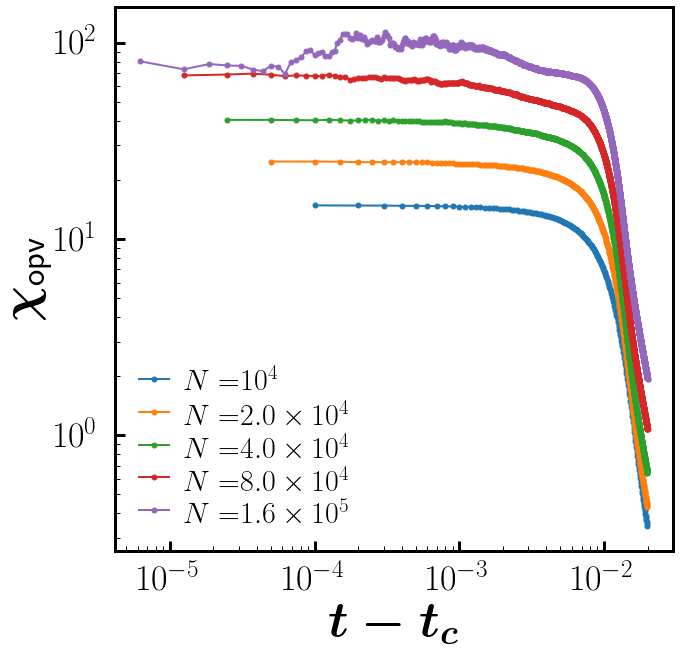

In [254]:
fig, ax = plt.subplots()
ax.set_rasterized(True)

t_c, x, nu_bar = 0.929, 0.71, 10.0
# t_c, x, nu_bar = 0.939, 1.15, 5.2
gamma = x * nu_bar
print("Gamma: " + str(gamma) + ", nu_bar: " + str(nu_bar))


def plotGamma(region, net, scaled):
    for networkSize in [10000, 20000, 40000, 80000, 160000]:
        current = networkSize, acceptanceThreshold
        if net:
            t, chi = netOrderParameterVariance[current]["78super"]
        else:
            t, chi = time[networkSize]*networkSize, orderParameterVariance[current]
        if region == "sub":
            reduced_t = t_c * networkSize - t
            reduced_t, chi = avgLogBin(reduced_t[reduced_t > 0], chi[reduced_t > 0], delta_exponent=0.03)
        elif region == "super":
            reduced_t = t - t_c * networkSize
            reduced_t, chi = reduced_t[reduced_t > 0], chi[reduced_t > 0]
            reduced_t, chi = reduced_t[reduced_t < 2e-2 * networkSize], chi[reduced_t < 2e-2 * networkSize]
            # reduced_t, chi = avgLogBin(reduced_t[reduced_t < 5e-2*networkSize], chi[reduced_t < 5e-2 * networkSize], delta_exponent=0.01)
        reduced_t /= networkSize
        if scaled:
            ax.plot(reduced_t * np.power(networkSize, 1 / nu_bar), chi * np.power(networkSize, -x), 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), markersize=5, linewidth=2)
        else:
            ax.plot(reduced_t, chi, 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), markersize=5, linewidth=2)

    if scaled:
        ax.set_ylabel(latex_bold_string("\chi_\\text{opv} N^{-\gamma/\\bar{\\nu}}"))
        if region == "sub":
            ax.set_xlabel(latex_bold_string("(t_c-t)N^{1/\\bar{\\nu}}"))
        elif region == "super":
            ax.set_xlabel(latex_bold_string("(t-t_c)N^{1/\\bar{\\nu}}"))
    else:
        ax.set_ylabel(latex_bold_string("\chi_\\text{opv}"))
        if region == "sub":
            ax.set_xlabel(latex_bold_string("t_c-t"))
        elif region == "super":
            ax.set_xlabel(latex_bold_string("t-t_c"))


plotGamma("super", net=True, scaled=False)
# x = np.array([0.05, 0.09])
# y = np.power(x, -gamma) * 1e-11
# ax.plot(x,y,'k--', label=latex_string("\\gamma=") + latex_float(gamma, 2))

# plotGamma("super", net=False, scaled=True)
# x = np.array([0.03, 0.08])
# y = np.power(x, -gamma) * 1e-11
# ax.plot(x,y,'k--', label=latex_string("\\gamma=") + latex_float(gamma, 2))


ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc="best", fontsize=30)

fig.show()


Gamma: 7.5, nu_bar: 30.0


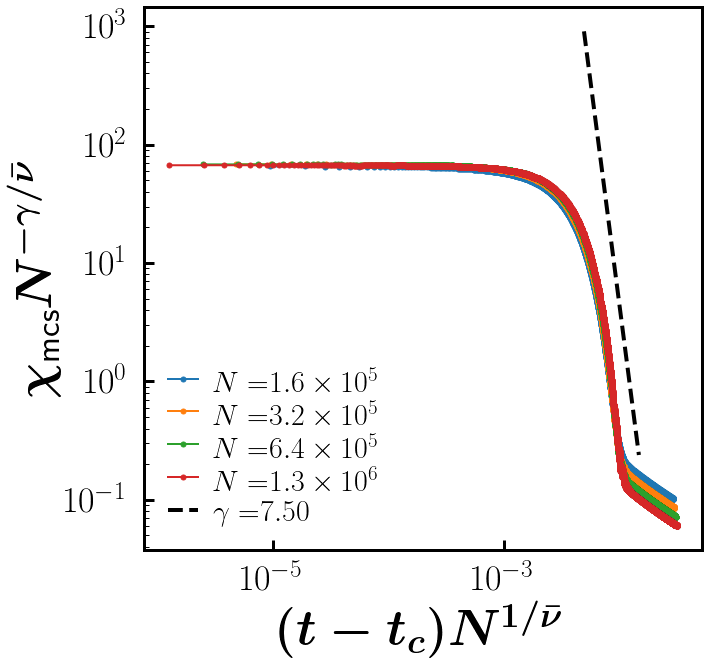

In [252]:
fig, ax = plt.subplots()
ax.set_rasterized(True)

t_c, x, nu_bar = 0.937, 0.25, 30.0
gamma = x * nu_bar
print("Gamma: " + str(gamma) + ", nu_bar: " + str(nu_bar))

def plotGamma(region, scaled):
    for networkSize in [160000, 320000, 640000, 1280000]:
        current = networkSize, acceptanceThreshold
        t, chi = time[networkSize] * networkSize, meanClusterSize[current]
        if region == "sub":
            reduced_t = t_c * networkSize - t
            reduced_t, chi = reduced_t[reduced_t>0], chi[reduced_t>0]
            # reduced_t, chi = avgLogBin(reduced_t[reduced_t > 0], chi[reduced_t > 0], delta_exponent=0.03)
        elif region == "super":
            reduced_t = t - t_c * networkSize
            reduced_t, chi = reduced_t[reduced_t > 0], chi[reduced_t > 0]
            reduced_t, chi = reduced_t[reduced_t < 2e-2 * networkSize], chi[reduced_t < 2e-2 * networkSize]
            # reduced_t, chi = avgLogBin(reduced_t[reduced_t < 5e-2*networkSize], chi[reduced_t < 5e-2 * networkSize], delta_exponent=0.01)
        reduced_t /= networkSize
        if scaled:
            ax.plot(reduced_t * np.power(networkSize, 1 / nu_bar), chi * np.power(networkSize, -x), 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), markersize=5, linewidth=2)
        else:
            ax.plot(reduced_t, chi, 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), markersize=5, linewidth=2)

    if scaled:
        ax.set_ylabel(latex_bold_string("\chi_\\text{mcs} N^{-\gamma/\\bar{\\nu}}"))
        if region == "sub":
            ax.set_xlabel(latex_bold_string("(t_c-t)N^{1/\\bar{\\nu}}"))
        elif region == "super":
            ax.set_xlabel(latex_bold_string("(t-t_c)N^{1/\\bar{\\nu}}"))
    else:
        ax.set_ylabel(latex_bold_string("\chi_\\text{mcs}"))
        if region == "sub":
            ax.set_xlabel(latex_bold_string("t_c-t"))
        elif region == "super":
            ax.set_xlabel(latex_bold_string("t-t_c"))


plotGamma("super", scaled=True)

x = np.array([0.005, 0.015])
y = np.power(x, -gamma) * 5e-15
ax.plot(x,y,'k--', label=latex_string("\\gamma=") + latex_float(gamma, 2))

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc="best", fontsize=30)

fig.show()


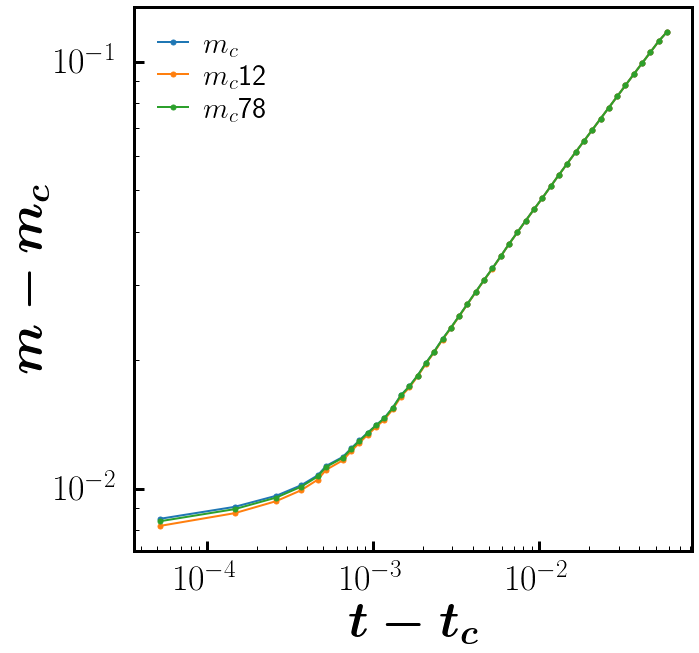

In [5]:
fig, ax = plt.subplots()
ax.set_rasterized(True)

acceptanceThreshold = 0.5
t_c = 0.9398
m_c = 0.88

x, nu_bar = 0.1, 3.0
beta = x * nu_bar

def plotTOP(scaled):
    # for networkSize in networkSizeList:
    for networkSize in [1280000]:
        current = networkSize, acceptanceThreshold
        for accumulate in ["", "12", "78"]:
            net_t, net_op = avgLinBin(*netOrderParameter[current][accumulate + "super"], min_val=0, max_val=networkSize - 1, delta=networkSize / 1e4)
            reduced_t, reduced_op = net_t - t_c * networkSize, net_op - m_c
            reduced_t, reduced_op = reduced_t[reduced_t > 0], reduced_op[reduced_t > 0]
            reduced_t, reduced_op = avgLogBin(reduced_t, reduced_op, delta_exponent=0.05)
            reduced_t /= networkSize

            if scaled:
                ax.plot(reduced_t * np.power(networkSize, 1.0 / nu_bar), reduced_op * np.power(networkSize, x), 'o-', label=latex_string("m_c") + accumulate, linewidth=2, markersize=5)
            else:
                ax.plot(reduced_t, reduced_op, 'o-', label=latex_string("m_c") + accumulate, linewidth=2, markersize=5)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(loc="best", fontsize=30)
    if scaled:
        ax.set_xlabel(latex_bold_string("(t-t_c)N^{1/\\bar{\\nu}}"))
        ax.set_ylabel(latex_bold_string("(m-m_c)N^{\\beta/\\bar{\\nu}}"))
    else:
        ax.set_xlabel(latex_bold_string("t-t_c"))
        ax.set_ylabel(latex_bold_string("m-m_c"))

# plotTOP(scaled=True)
plotTOP(scaled=False)

fig.show()
